In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import r_regression
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load and prepare striatal mask

mask = nib.load('/content/drive/MyDrive/1 Sagol Project/Mask/Tian_Subcortex_S3_3T.nii').get_fdata()

striatum = list(range(11, 19)) + list(range(22,24)) + list(range(36, 44)) + list(range(47,49))


bool_mask = np.isin(mask, striatum)

mask[~bool_mask] = 0
mask[bool_mask] = 1

mask = mask.flatten()
mask = np.stack([mask for i in range(0,50)])
mask = np.transpose(mask)

In [ ]:
# establish data paths

fmri_folder_path = '/content/drive/MyDrive/1 Sagol Project/Features/'
pet_folder_path = '/content/drive/MyDrive/1 Sagol Project/PET/'

In [ ]:
# load PET data

Y = []

for file in os.listdir(pet_folder_path):
  file_path = os.path.join(pet_folder_path, file)
  temp_pet = nib.load(file_path).get_fdata()
  temp_pet = temp_pet.flatten()[mask[:,0] != 0]
  Y.append(temp_pet)


In [ ]:
# load FC data

X = []

for file in os.listdir(fmri_folder_path):
  file_path = os.path.join(fmri_folder_path, file)
  temp_fmri = nib.load(file_path).get_fdata()
  temp_fmri = temp_fmri.reshape(-1, temp_fmri.shape[-1])
  temp_fmri = temp_fmri[~np.all(mask == 0, axis=1)]
  X.append(temp_fmri)

In [ ]:
# LOO-CV prediction routine

original_Y = Y.copy()
r_matrix = np.zeros((26,26))
batch_pred = np.zeros(Y[25].shape)

for i in range(26):

  batch_feat = X[25]

  for j in range(Y[0].shape[0]):

    features = np.array([X[i][j] for i in range(len(X)-1)])
    target = np.array([Y[i][j] for i in range(len(Y)-1)])
    ols = LinearRegression().fit(features, target)
    batch_pred[j] = ols.predict((batch_feat[j].reshape(1, -1)))

  r_list = [r_regression(original_Y[k].reshape(-1,1), batch_pred)[0] for k in range(len(Y))]
  r_matrix[:,25-i] = np.array(r_list)

  X.insert(0, X.pop(25))
  Y.insert(0, Y.pop(25))


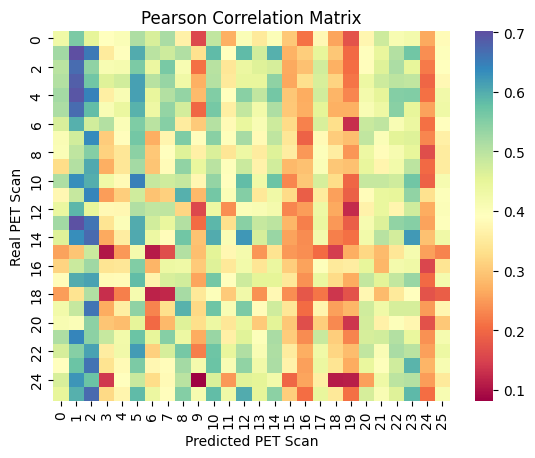

In [ ]:
fig = sns.heatmap(r_matrix, cmap = 'Spectral')
fig.set_title('Pearson Correlation Matrix')
fig.set(xlabel='Predicted PET Scan', ylabel='Real PET Scan')
plt.show()

In [ ]:
# calculate mean correlation value along the diagonal and for the whole matrix

r_diag = np.array([r_matrix[i,i] for i in range(26)])
r_diag_mean = r_diag.mean()
r_mean = r_matrix.mean()
[r_mean, r_diag_mean]

[0.4035267528340351, 0.4365858698532329]

In [ ]:
# fast permutation test (N = 100000)
# shuffles the correlation matrix row-wise N times
# and finds in which fraction of iterations the correlation value along
# the diagonal is larger or equal to the original diagonal mean

shuffled_r_diag = np.zeros(100000)
shuffled_r_diag[0] = r_diag_mean
for i in range(1,100000):
  np.random.shuffle(r_matrix.flat)
  shuffled_r_diag[i] = np.array([r_matrix[i,i] for i in range(26)]).mean()

p_value = np.sum(shuffled_r_diag >= r_diag_mean)/100000
p_value

0.08275